In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [127]:
X = pd.read_csv('./bigger.csv')
X = X[X['Timestamp']!='0']
X['Timestamp'] = pd.to_datetime(X['Timestamp'],format='%Y/%m/%d %H:%M')
# data are expressed in local time, convert to standard time
X.set_index('Timestamp',inplace=True)
X.index = X.index.tz_localize('Europe/Dublin',ambiguous='infer')
X.index = X.index.tz_convert('UTC')
X = X[~X.index.duplicated()] # drop duplicates - IMPORTANT, do after conversion to UTC
## Resample to regular 5 minutes by upsampling to 1 min, interpolating and then resample at 5 min
X = X.resample('1T').asfreq().interpolate('linear').resample('5T').asfreq()

X['NEPowerKW'] = X[' NE array W']/1000 # W to KW
X['SWPowerKW'] = X[' SW array W']/1000 # W to KW
X.drop(columns=[' NE array W',' SW array W'],inplace=True)
# kW is the instantaneous power generated by the panel at that instant
#  - This quantity can be very volatile and difficult to predict. 
#  - It is better to consider kwh/h, which is a smoother quantity representing the average power over an interval, kwh/h

#kwh is the cumulated energy generated by the solar panel
#kwh/h is average power generated over the hour, calculated as:
# (1) energy generated over the interval divided by the interval length
# (2) integral (sum) of power over the interval divided by the interval length
X['kwh/h-1'] = X[' kWh'].diff()*(60/5) 
X['NE-kwh/h-2'] = X['NEPowerKW'].rolling(int(60/5)).sum()*(5/60)
X['SW-kwh/h-2'] = X['SWPowerKW'].rolling(int(60/5)).sum()*(5/60)
X['kwh/h-2'] = X['NE-kwh/h-2'] + X['SW-kwh/h-2']


<IPython.core.display.Javascript object>


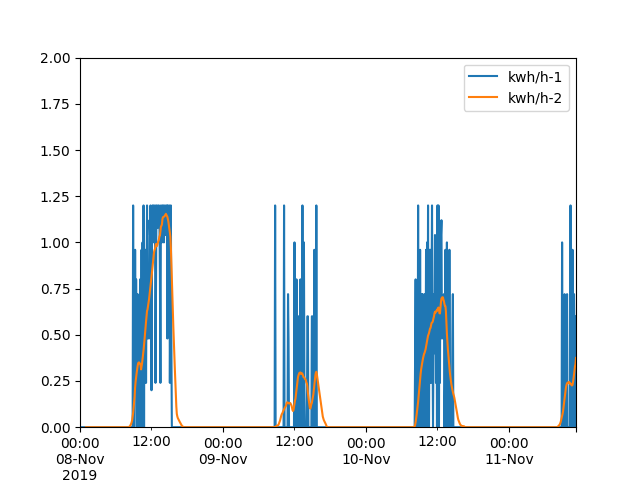

(0.0, 2.0)

In [117]:
# Quantization error on kwh data causes calculation (1) for kwh/h very noisy
# Best to use calculation (2) to go from kW -> kwh/h 
X[['kwh/h-1','kwh/h-2']].iloc[:1000].plot()
plt.ylim([0,2])

<IPython.core.display.Javascript object>


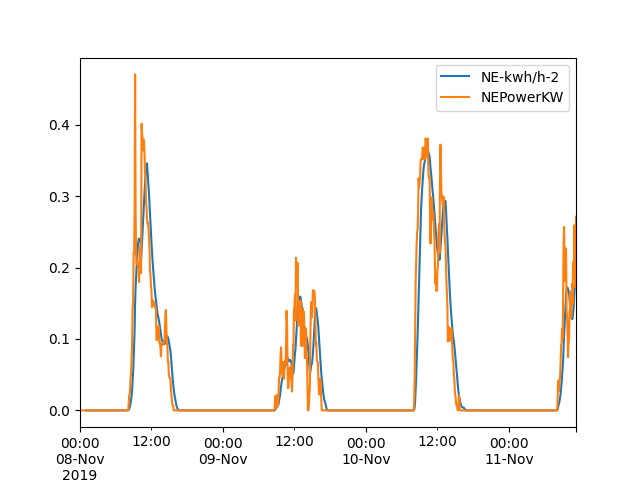

<IPython.core.display.Javascript object>


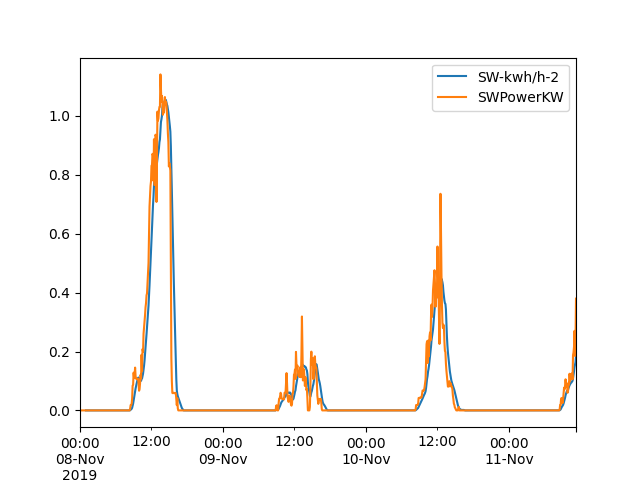

<AxesSubplot:xlabel='Timestamp'>

In [118]:
# Comparing kW and kWh/h
# - kwh/h is smoother than kW as it represents average within an interval rather than instantaneous
# - kwh/h is delayed with respect to kW by the number of samples used for the averaging (in this case 60/5 samples or 1 hour).
X[['NE-kwh/h-2','NEPowerKW']].iloc[:1000].plot()
X[['SW-kwh/h-2','SWPowerKW']].iloc[:1000].plot()


In [133]:
## Load weather data
# assuming weather.json is the output of the weather historical api
import json
with open('./weather.json','r') as fin:
    weatherJs = json.load(fin)
weatherPd = pd.DataFrame(weatherJs['weatherData']['hourly']['hours'])

#convert irradiance to KWsqm
weatherPd['directNormalIrradianceKWsqm'] = weatherPd['directNormalIrradianceWsqm']/1000
weatherPd.drop(columns=['directNormalIrradianceWsqm'],inplace=True)

#keep only GMT timestamp and make index
weatherPd.drop(columns=['dateHrLwt'],inplace=True)
weatherPd['dateHrGmt'] = pd.to_datetime(weatherPd['dateHrGmt'])
weatherPd.set_index('dateHrGmt',inplace=True)
weatherPd.index = weatherPd.index.tz_localize('UTC')

In [140]:
## Align weather data with solar power data

#Up-sample weather to 5 min with linear interpolation to align with solar power data 
weatherPd5min = weatherPd.resample('5T').asfreq().interpolate('linear')
# Copmute rolling average of weather to align with kwh/h
weatherPd5min = weatherPd5min.rolling(int(60/5)).sum()*(5/60)

# merge
Xall = X.merge(weatherPd5min,left_index=True,right_index=True).dropna()

<IPython.core.display.Javascript object>


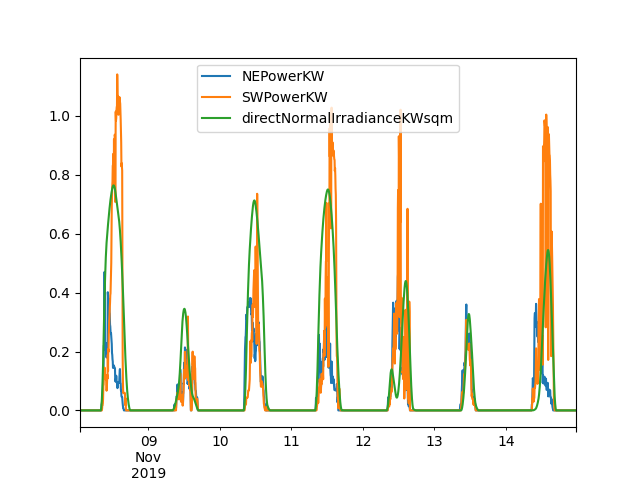

<IPython.core.display.Javascript object>


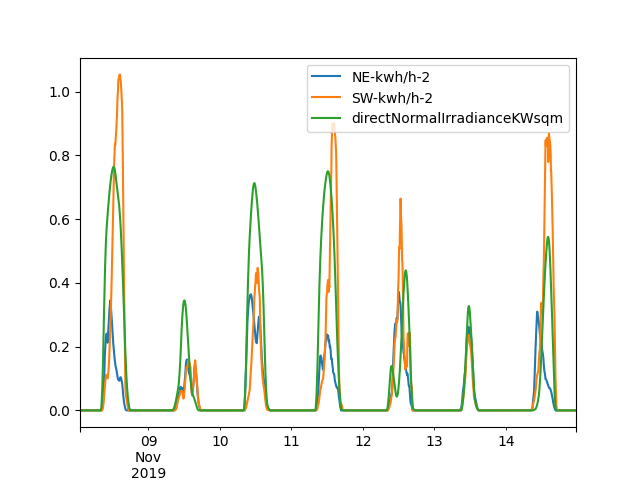

<AxesSubplot:>

In [141]:
## Check alignment of solar irradiance with solar power
Xall[['NEPowerKW','SWPowerKW','directNormalIrradianceKWsqm']].iloc[:2000].plot()

## Check alignment of solar irradiance with average solar power in kwh/h
Xall[['NE-kwh/h-2','SW-kwh/h-2','directNormalIrradianceKWsqm']].iloc[:2000].plot()


In [ ]:
## Modeling example 
# Now we can fit a predictive model to the data 
